In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from src import myfunctions
import statsmodels.api as sm
from scipy import signal
import scipy as sp
import warnings

warnings.filterwarnings('ignore')

##  Data import cleaning and checks

In [2]:
# note that for Windows Python 3.8. you need to use ./ to indicate parent directory
# in some other systems it might be ../

df=pd.read_csv("./input/attacks.csv", encoding='ISO-8859-1')

In [3]:
# Function cleaning will clean all the relevant columns like Date, Year, Country, Sex, Age, Species

df2=myfunctions.cleaning(df)

In [4]:
# Given that prior to 1850 there are very few records, we will start data from 1800

df_recent=df2[(df2['Year']>=1850)]

In [5]:
df_recent.head()

,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal,Time,Species,Source,Month
0,25-Jun-2018,2018,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,White shark,"R. Collier, GSAF",Jun
1,18-Jun-2018,2018,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,Minor injury to left thigh,N,14h00 -15h00,Shark,"K.McMurray, TrackingSharks.com",Jun
2,09-Jun-2018,2018,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,Injury to left lower leg from surfboard skeg,N,07h45,Shark,"K.McMurray, TrackingSharks.com",Jun
3,08-Jun-2018,2018,Unprovoked,Australia,New South Wales,Arrawarra Headland,Surfing,male,M,0,Minor injury to lower leg,N,NaN,Shark,"B. Myatt, GSAF",Jun
4,04-Jun-2018,2018,Provoked,Mexico,Colima,La Ticla,Free diving,Gustavo Ramos,M,0,Lacerations to leg & hand shark PROVOKED INCIDENT,N,NaN,Tiger shark,A .Kipper,Jun


## 1. Data description

In the paragraphs below I will describe the data set in high level, showing the timeline, list of countries, age of people involved and species of sharks as well as activities that are most affected by shark attacks.

#### Timeline

<AxesSubplot:xlabel='Year', ylabel='Count'>

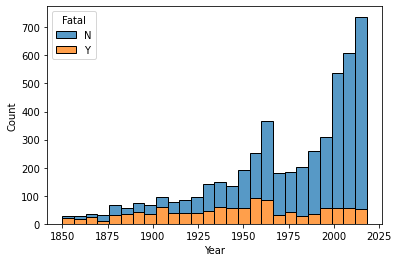

In [6]:
sns.histplot(data=df_recent, x='Year', hue='Fatal', multiple='stack')

There is a steady rise of shark attacks over the years, this is most likely led by the fact that more people are participating in water sports activities.

In [7]:
# Create a new dataframe called year_stats where each year is summarized
year_stats=myfunctions.year_stats(df_recent)
year_stats.tail()

,Year,Fatality rate,Fatality rate male,Fatality rate female,Fatality rate 5y_avg,Fatality rate male 5y_avg,Fatality rate female 5y_avg
164,2014,6.363636,6.818182,4.545455,9.461415,10.177030,5.390884
165,2015,7.031250,5.714286,13.043478,9.218181,9.477782,7.047198
166,2016,4.310345,3.157895,9.523810,7.624109,7.364263,8.951960
167,2017,5.882353,6.024096,5.555556,7.018402,6.426225,10.063071
168,2018,1.960784,2.222222,0.000000,5.109674,4.787336,6.533660


<AxesSubplot:xlabel='Year', ylabel='Fatality rate'>

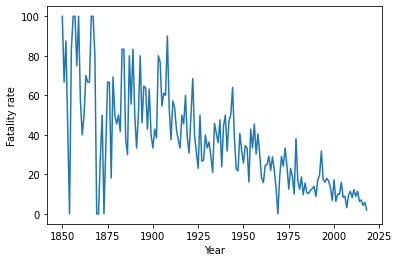

In [8]:
sns.lineplot(data=year_stats, x='Year', y='Fatality rate')

Interestingly despite the increase in the total cases the fatality rate of shark attacks has decreased steadily. The data is quite sparse, so below I do a 5 year average on the series.

<AxesSubplot:xlabel='Year', ylabel='Fatality rate 5y_avg'>

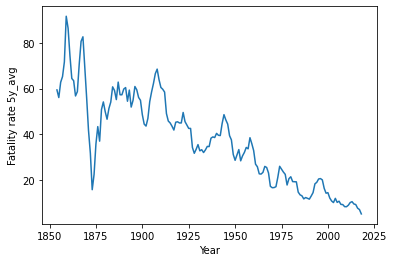

In [9]:
sns.lineplot(data=year_stats, x='Year', y='Fatality rate 5y_avg')

The decrease in deadly attacks could be attributed to better security measures and people being more carefull, or simply to better reporting - meanung that in the past the attack was not reported if it was not serious or not fatal. In the end it is a bit of both.

<AxesSubplot:xlabel='Sex', ylabel='count'>

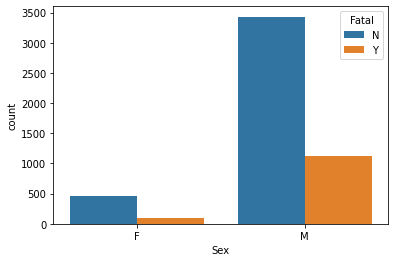

In [10]:
sns.countplot(data=df2, x="Sex", hue="Fatal")

It is quite obvious that men are more likely to get into a shark attack as they are known to take more risk. It also appears that overall female fatality rate from accidents is lower. Next we see how the fatality rate differs between men and women over time.

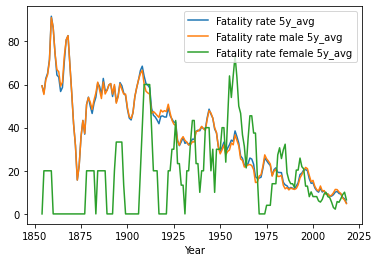

In [11]:
year_stats.plot(x='Year', y=['Fatality rate 5y_avg','Fatality rate male 5y_avg','Fatality rate female 5y_avg'], kind='line')
plt.show()

While overall women may have less fatal attacks, this figure tends to be quite volatile across time, for example in the 60s and 80s there were some episodes where female mortality from attacks exceeded male.

## 1.1 Countries

Here we want to investigate in which countries did the attacks mostly happen, and where they were the most fatal.

In [12]:
# A function called country_stats will create a new dataframe based on selected top number of countries, here we select 20
top20_df=myfunctions.country_stats(df_recent, 20)

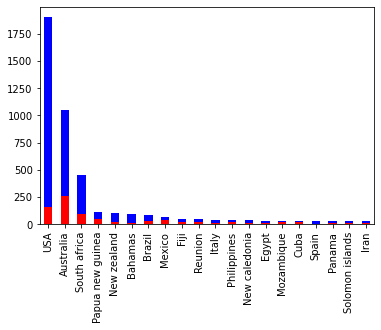

In [13]:
top20_df['Fatal'].plot(y='Fatal',use_index=True, kind='bar', color='r')
top20_df['Not fatal'].plot(y='Not fatal',use_index=True, kind='bar', bottom=top20_df['Fatal'], color='b')
plt.show()

The bar chart shows that most of the attacks happen in three countries: USA; Australia and South Africa. It is not surprising as these are the most popular surfing destinations (think California or Hawaii in USA or Bondi Beach in Australia), as well as having a lot of sharks on their shores.

<AxesSubplot:>

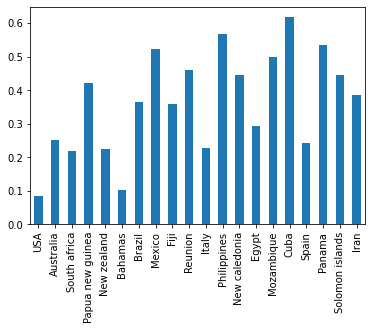

In [14]:
top20_df['Fatality rate'].plot(y='Fatality rate',use_index=True, kind='bar')

If we look at the fatality rate of shark attacks it looks very different - most of the shark attacks in the USA are not fatal. It is actually more fatal in Mexico or Philipines for example.

## 1.2 Sharks

What kind of sharks are being involved in these attacks?

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'White shark'),
  Text(1, 0, 'Shark'),
  Text(2, 0, 'Tiger shark'),
  Text(3, 0, 'Bull shark'),
  Text(4, 0, 'Wobbegong shark'),
  Text(5, 0, 'Blacktip shark'),
  Text(6, 0, 'Blue shark')])

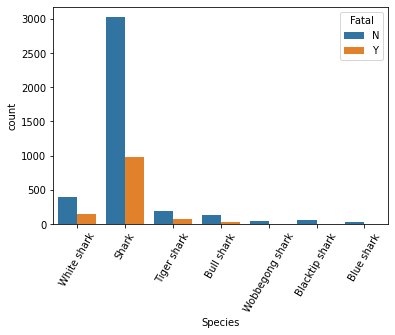

In [15]:
# Define the sharks and where they are mostly found
sns.countplot(data=df2, x="Species", hue="Fatal")
plt.xticks(rotation=60)

Most of the sharks are not clearly identified with names like "3m shark" or "6' shark" or "something that looks like a shark". Therefore these were replaced by simply Shark. Names like "3m white shark" or "Great White shark" were properly mapped and replaced by White shark.

As you can see from the list, besides the misleading names, the most common species involved in attacks is the White shark followed by the Tiger shark.

## 1.3 Activities

Which are the activities where the most shark of attacks happen?

In [16]:
df2['Activity'].value_counts()[:10]

Surfing           1223
Swimming          1098
Fishing           1026
Diving             388
Standing           124
Snorkeling          95
Free diving         83
Treading water      30
Kayaking            30
Fell overboard      29
Name: Activity, dtype: int64

In [17]:
top10_activity_df=myfunctions.activity_stats(df2,10)

<AxesSubplot:>

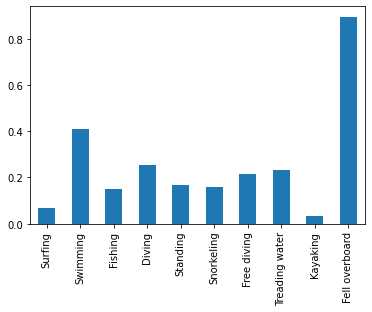

In [18]:
top10_activity_df['Fatality rate'].plot(y='Fatality rate',use_index=True, kind='bar')

While surfing, fishing and diving are the top activities, their fatality rate differs a lot. Swimmers are more likely to perish in the shark attacks than surfers. And of course if you are the unlucky who fell overboard, chances of survival are quite slim.

# 2 Economic analysis

The main part of this reseach will focus on the historical analysis of shark attack occurencies and how does that correlate with some historical events and economic developments.

Given the data that we have seen in the charts above, we will focus on United States, which have the largest and the most reliable dataset on shark attacks.

This part of the research will focus on two hypothesses:

1. The start of the hippie movement that started in the 1960s has lead to more people addopting going into surfing - the hypothesis will check if this resulted in more shark attacks due to surfing.

2. If we remove the upward trend in shark attacks which is linked to surfing getting more popular in general, the remaining variation will be positively correlated to unemployment rate.



## 2.1 The USA dataset

In [19]:
df_usa=df2[(df2['Country']=='USA')&(df2['Year']>=1850)] # USA from year 1850
df_usa['Activity'].value_counts()[:10]

Surfing        689
Fishing        348
Swimming       348
Diving          93
Standing        65
Free diving     29
Snorkeling      27
Kayaking        17
Walking         10
Floating         8
Name: Activity, dtype: int64

As seen from the dataset above the top activities for being caught in a shark attack are Surfing, Fishing, Swiming and Diving. We look in more detail at these top activities:

<AxesSubplot:xlabel='Year', ylabel='Count'>

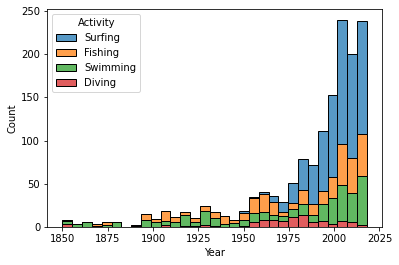

In [20]:
sns.histplot(data=df_usa[df_usa['Activity'].isin(['Swimming','Surfing','Fishing','Diving'])], x='Year', hue='Activity', multiple='stack')

## 2.2 Hypothesis 1 - Hippie revolution caused increase in surfer shark attacks

First we look at the histogram of surfing shark attacks in the USA

<AxesSubplot:xlabel='Year', ylabel='Count'>

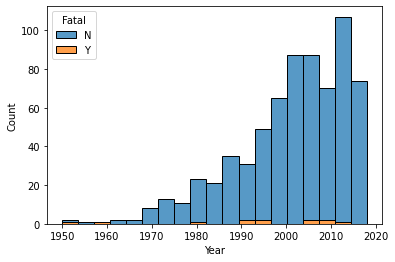

In [27]:
sns.histplot(data=df_usa[df_usa['Activity'].isin(['Surfing'])], x='Year', hue='Fatal', multiple='stack')

While the current dataset analyzed is from 1850, the surfing as activity in shark attacks list first appears only in 1950s, and with the real pick up at the end of 1960s.

So it is safe to say that ***the hippie revolution did spark more surfing*** activity which is evident from higher number of shark attacks. But despite that the hippie period is over surfing remains to be a popular sport and attract a lot of shark attacs.

## 2.3 Hypothesis 2 - Correlation of shark attacks to unemployment rate in the US

The second and the most important hypothesis of the report is to prove that there is a correlation of shark attacks to the unemployment rate in the US.

First we will import the unemployment data from the St.Lewis FED database FRED, the link to the dataseries is here:
https://fred.stlouisfed.org/series/UNRATE

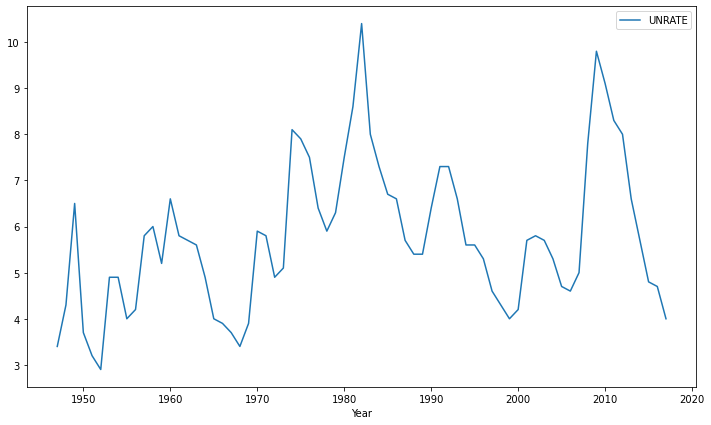

In [22]:
unrate=pd.read_csv("./input/UNRATE.csv")
unrate.plot(x='Year', y='UNRATE', kind='line', figsize=(12,7))
plt.show()

Use the Unemployment rate dataframe to add information about the shark attacks in the USA

In [23]:
unrate=myfunctions.usa_database(unrate,df_usa)


Do a scatter plot of how the unemployment rate relates to the total number of shark attacks, but also to the top 3 activities involved in shark attacks. See if there is any relationship.

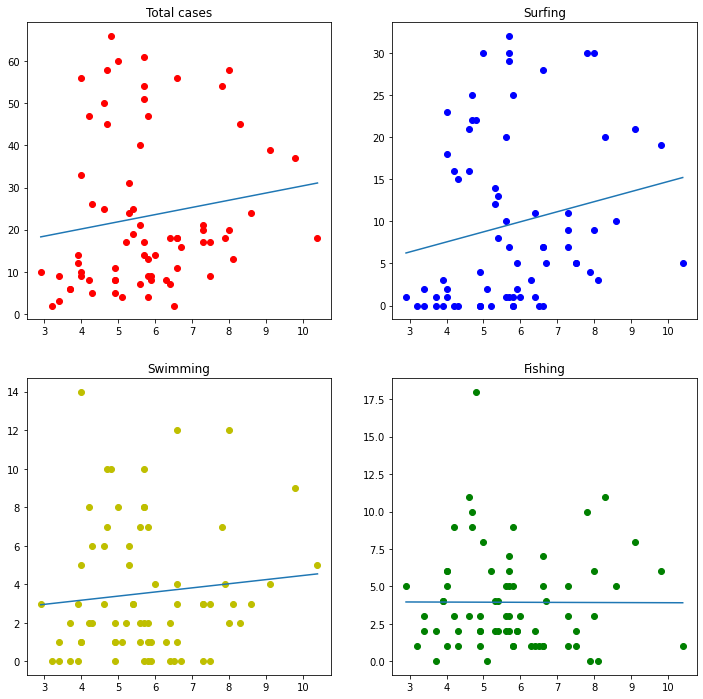

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0, 0].plot(unrate['UNRATE'], unrate['Cases'], 'ro')
axs[0, 0].set_title('Total cases')
axs[0, 0].plot(np.unique(unrate['UNRATE']), np.poly1d(np.polyfit(unrate['UNRATE'], unrate['Cases'], 1))(np.unique(unrate['UNRATE'])))
axs[0, 1].plot(unrate['UNRATE'], unrate['Surfing'], 'bo')
axs[0, 1].set_title('Surfing')
axs[0, 1].plot(np.unique(unrate['UNRATE']), np.poly1d(np.polyfit(unrate['UNRATE'], unrate['Surfing'], 1))(np.unique(unrate['UNRATE'])))
axs[1, 0].plot(unrate['UNRATE'], unrate['Swimming'], 'yo')
axs[1, 0].set_title('Swimming')
axs[1, 0].plot(np.unique(unrate['UNRATE']), np.poly1d(np.polyfit(unrate['UNRATE'], unrate['Swimming'], 1))(np.unique(unrate['UNRATE'])))
axs[1, 1].plot(unrate['UNRATE'], unrate['Fishing'], 'go')
axs[1, 1].set_title('Fishing')
axs[1, 1].plot(np.unique(unrate['UNRATE']), np.poly1d(np.polyfit(unrate['UNRATE'], unrate['Fishing'], 1))(np.unique(unrate['UNRATE'])))




As seen from the four charts above there is some positive correlation between shark attacks and the unemployment rate. The relationship as described by the slope of the regression line is the strongest with attacks while surfing.

What this means is that the higher unemployment rate results in higher shark attacks while surfing through either more people taking to surfing, or amateur surfers coming from the corporate world and getting caught in shark attacks.

In either way it is clear that higher unemployment leads to more shark attacks - **please keep unemployment low!**